In [7]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/Users/dhruval/Documents/pranavCNN1'):
    print(dirname)


/Users/dhruval/Documents/pranavCNN1
/Users/dhruval/Documents/pranavCNN1/car-plate-detection
/Users/dhruval/Documents/pranavCNN1/car-plate-detection/xml_files_pt2
/Users/dhruval/Documents/pranavCNN1/car-plate-detection/images


In [5]:
import xml.etree.ElementTree as xet
from glob import glob
import re
import cv2

In [11]:
dataset_path = '/Users/dhruval/Documents/pranavCNN1/car-plate-detection'
match = re.search(r'\d+',"filename123.html")
match.group()

'123'

In [12]:
def num_in_name(filename):
    """This will find number in the file if not no. then return 0"""
    match = re.search(r'\d+',filename)
    
    if match:
        return int(match.group(0))
    else:
        return 0

In [13]:
filename = glob(f"{dataset_path}/annotations/*.xml")
len(filename), filename[0]

(900,
 '/Users/dhruval/Documents/pranavCNN1/car-plate-detection/annotations/162.xml')

In [14]:
data_dict = dict(img_path=[], 
    xmin=[], ymin=[],
    xmax=[], ymax=[],
    img_w=[], img_h=[])

filepaths = glob(f"{dataset_path}/annotations/*.xml")

for filepath in sorted(filepaths, key=num_in_name):
    parser = xet.parse(filepath)
    root = parser.getroot()
    
    objectData = root.find("object")
    bndbox = objectData.find("bndbox")
    
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
    
    imgTensor = cv2.imread(img_path)
    height, width, _ = imgTensor.shape
    
    data_dict["img_path"].append(img_path)
    data_dict["xmin"].append(xmin)
    data_dict["ymin"].append(ymin)
    data_dict["xmax"].append(xmax)
    data_dict["ymax"].append(ymax)
    data_dict["img_w"].append(width)
    data_dict["img_h"].append(height)
    
df = pd.DataFrame(data_dict)
df.head()
    

img_path  xmin  ymin  xmax  ymax  \
0  /Users/dhruval/Documents/pranavCNN1/car-plate-...   412   379   556   470   
1  /Users/dhruval/Documents/pranavCNN1/car-plate-...   365   419   477   443   
2  /Users/dhruval/Documents/pranavCNN1/car-plate-...   329   439   517   467   
3  /Users/dhruval/Documents/pranavCNN1/car-plate-...   154   237   248   267   
4  /Users/dhruval/Documents/pranavCNN1/car-plate-...   658   301   762   359   

   img_w  img_h  
0    729    547  
1    787    474  
2    850    477  
3    409    547  
4    821    491

In [15]:

filepaths = glob(f"{dataset_path}/annotations/*.xml")
num=0
for filepath in sorted(filepaths, key=num_in_name):
    if num==4:
        break
    num+=1
    print(filepath)

/Users/dhruval/Documents/pranavCNN1/car-plate-detection/annotations/162.xml
/Users/dhruval/Documents/pranavCNN1/car-plate-detection/annotations/604.xml
/Users/dhruval/Documents/pranavCNN1/car-plate-detection/annotations/88.xml
/Users/dhruval/Documents/pranavCNN1/car-plate-detection/annotations/610.xml


In [16]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=42)

train, val = train_test_split(train, test_size=1/9, random_state=42)

train.shape, test.shape, val.shape

((720, 7), (90, 7), (90, 7))

In [17]:
import os
import shutil
import pandas as pd

if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [18]:
def create_yolo_folder(name,dataframe):

    labels_path = os.path.join("datasets","car_plate",name,"labels")
    image_path = os.path.join("datasets","car_plate",name,"images")
    
    os.makedirs(labels_path,exist_ok=True)
    os.makedirs(image_path,exist_ok=True)
    
    for _,row in dataframe.iterrows():
        
        image_name, image_extension = os.path.splitext(os.path.basename(row["img_path"]))
        
        x_center = (row["xmin"] + row["xmax"])/2/row["img_w"]
        y_center = (row["ymin"] + row["ymax"])/2/row["img_h"]
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']
        
        label_path = os.path.join(labels_path, f"{image_name}.txt")
        
        with open(label_path,"w") as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
         
        shutil.copy(row["img_path"],os.path.join(image_path,image_name+image_extension))
    
    print(f"Created '{image_path}' and '{label_path}'")
        

In [19]:
create_yolo_folder("train",train)
create_yolo_folder("test",test)
create_yolo_folder("validation",val)

Created 'datasets/car_plate/train/images' and 'datasets/car_plate/train/labels/521.txt'
Created 'datasets/car_plate/test/images' and 'datasets/car_plate/test/labels/119.txt'
Created 'datasets/car_plate/validation/images' and 'datasets/car_plate/validation/labels/464.txt'


In [20]:
import matplotlib.pyplot as plt
import random
os.getcwd()

'/Users/dhruval/Documents/pranavCNN1'

In [23]:
image_dir = "datasets/car_plate/train/images"
labels_dir = "datasets/car_plate/train/labels"

def get_image(image_name):

    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(labels_dir, f"{os.path.splitext(image_name)[0]}.txt")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(label_path,"r") as file:
        lines = file.readlines()

    for line in lines:
        class_id,x_center,y_center,width,height = map(float, line.strip().split())
        print(class_id,x_center,y_center,width,height)


        image_height, image_width, _ = image.shape
        #print(image_h,image_w)
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height
        #print(x_center,y_center,width,height)
        x1 = int(x_center - width/2)
        y1 = int(y_center - height/2)
        x2 = int(x_center + width/2)
        y2 = int(y_center + height/2) 
        cv2.rectangle(img=image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)


    plt.imshow(image)
    plt.axis('off')  
    plt.show() 

In [24]:
image_list = os.listdir(image_dir)

0.0 0.3847 0.8218 0.1459 0.109


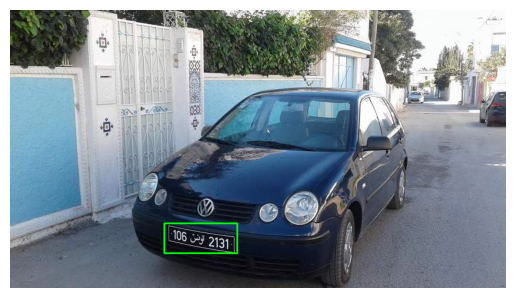

In [27]:
get_image(random.choice(image_list))

In [28]:
# creating dataset.ymal file
dataset_yaml = """

# root dir
path: car_plate

# Directories
train: train/images
val: validation/images
test: test/images

# number of class
nc: 1

# class name
names: ['licence_plate']

"""

with open("datasets.yaml","w") as file:
    file.write(dataset_yaml)

In [31]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [36]:
import os

base_path = "/Users/dhruval/Documents/pranavCNN1/datasets/car_plate"
assert os.path.exists(os.path.join(base_path, "train/images")), "Training images path is incorrect!"
assert os.path.exists(os.path.join(base_path, "validation/images")), "Validation images path is incorrect!"
assert os.path.exists(os.path.join(base_path, "test/images")), "Test images path is incorrect!"
print("Paths are correct!")


Paths are correct!


In [37]:

model.train(
    data="datasets.yaml",
    epochs=100,
    batch=16,
    imgsz=320,
    cache=True 
)

New https://pypi.org/project/ultralytics/8.3.43 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.13 torch-2.4.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

train: Scanning /Users/dhruval/Documents/pranavCNN1/datasets/car_plate/train/labels... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<00:00, 2197.09it/s]

train: New cache created: /Users/dhruval/Documents/pranavCNN1/datasets/car_plate/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 720/720 [00:00<00:00, 1474.52it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/Users/dhruval/miniforge3/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /Users/dhruval/Documents/pranavCNN1/datasets/car_plate/validation/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 2616.44it/s]

val: New cache created: /Users/dhruval/Documents/pranavCNN1/datasets/car_plate/validation/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 90/90 [00:00<00:00, 2414.16it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.541      2.194      1.152         28        320: 100%|██████████| 45/45 [02:21<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]

                   all         90         90     0.0183      0.856      0.304      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.345      1.138      1.016         34        320: 100%|██████████| 45/45 [02:17<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

                   all         90         90      0.954      0.696       0.94      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.344       1.06      1.029         26        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]

                   all         90         90      0.879      0.886      0.938      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.292     0.9562      1.034         27        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.943      0.933      0.979      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.212     0.8309      1.005         27        320: 100%|██████████| 45/45 [02:18<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

                   all         90         90      0.945       0.96      0.976      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.217     0.8002      1.001         28        320: 100%|██████████| 45/45 [02:18<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]

                   all         90         90      0.974      0.956      0.985      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.145     0.7442     0.9933         27        320: 100%|██████████| 45/45 [02:20<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]

                   all         90         90      0.975      0.967      0.989      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G       1.16     0.7124     0.9846         33        320: 100%|██████████| 45/45 [02:17<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

                   all         90         90      0.978      0.988      0.992      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G       1.14     0.7148     0.9788         33        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]

                   all         90         90      0.984      0.967      0.992      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.163     0.7058     0.9752         34        320: 100%|██████████| 45/45 [02:39<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]

                   all         90         90      0.984      0.967      0.984      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.075     0.6488     0.9634         32        320: 100%|██████████| 45/45 [02:22<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]

                   all         90         90      0.974      0.956       0.99      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.106     0.6612     0.9619         32        320: 100%|██████████| 45/45 [02:18<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.984      0.956      0.988      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.077     0.6391     0.9586         33        320: 100%|██████████| 45/45 [02:17<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]

                   all         90         90      0.985      0.978      0.992      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.059     0.6254       0.95         28        320: 100%|██████████| 45/45 [02:18<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.995      0.978      0.993      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.066     0.6312     0.9391         23        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.968      0.995      0.991      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.049     0.6051      0.947         30        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.968      0.956      0.986      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.009     0.6014     0.9363         30        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.978      0.944      0.989      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.9915     0.5947     0.9279         32        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.35s/it]

                   all         90         90      0.984      0.967      0.992      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.9907     0.5648       0.92         32        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]

                   all         90         90          1      0.968      0.993      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.9921     0.5616     0.9354         27        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.966      0.954       0.98      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.9624     0.5658     0.9325         27        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.983      0.967      0.992      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.9786     0.5726     0.9301         37        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

                   all         90         90      0.976      0.967      0.991      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.013     0.5927     0.9267         29        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

                   all         90         90      0.985      0.978      0.993       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G     0.9107     0.5339     0.9059         27        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.998      0.978      0.992      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.9712     0.5481     0.9203         34        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.983          1      0.995      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      0.953     0.5454     0.9078         32        320: 100%|██████████| 45/45 [02:18<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.993      0.978      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.8892     0.5228     0.9026         25        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.989      0.963      0.991      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.9079     0.5155     0.9093         27        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

                   all         90         90          1      0.989      0.994      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.9022     0.5203     0.9045         29        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

                   all         90         90      0.988      0.956      0.993      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.9001     0.5293     0.9032         25        320: 100%|██████████| 45/45 [02:18<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]

                   all         90         90      0.992      0.978      0.993      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.8854     0.5113     0.9016         28        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.975      0.967      0.987      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.9078     0.5133     0.9015         25        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

                   all         90         90      0.989      0.972      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.8983     0.5118     0.9134         31        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]

                   all         90         90      0.983      0.978      0.994      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.8733       0.49     0.9065         27        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

                   all         90         90      0.975      0.956      0.986      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.8632     0.4942     0.9082         31        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.946      0.989      0.993      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.8648      0.499      0.905         24        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.946          1      0.993      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.8712     0.5017     0.8973         21        320: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.987      0.989      0.995      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.8562     0.4962     0.8875         29        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.979      0.978      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.8528     0.4829     0.8898         31        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.989      0.964      0.992      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.8191     0.4688     0.8844         30        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]

                   all         90         90      0.965      0.989      0.992      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.8123     0.4749      0.883         23        320: 100%|██████████| 45/45 [02:20<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.987          1      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.8257     0.4705     0.8875         34        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.45s/it]

                   all         90         90      0.971      0.978      0.993      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.8113      0.471      0.883         29        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.997      0.978      0.994      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.8041     0.4628     0.8871         31        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]

                   all         90         90      0.978      0.998      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.7982     0.4493     0.8785         33        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90       0.99      0.967      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.8084      0.452     0.8914         22        320: 100%|██████████| 45/45 [02:18<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.976      0.989      0.993      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.7908     0.4441     0.8773         25        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

                   all         90         90      0.961      0.989      0.993      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.7775     0.4479     0.8761         30        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

                   all         90         90      0.986          1      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G       0.78     0.4425       0.88         36        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]

                   all         90         90      0.998      0.989      0.994      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.7968     0.4455     0.8842         34        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

                   all         90         90      0.985      0.989      0.994      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.7763     0.4503     0.8678         32        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.967          1      0.991      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.7804     0.4473     0.8731         34        320: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]

                   all         90         90      0.952          1      0.994      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8064     0.4571     0.8822         34        320: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.996      0.978      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.7491     0.4282     0.8742         28        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]

                   all         90         90      0.968      0.997      0.987      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.7629     0.4391     0.8673         34        320: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all         90         90      0.964          1      0.993      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.7766      0.438     0.8696         26        320:  53%|█████▎    | 24/45 [01:18<01:08,  3.26s/it]


KeyboardInterrupt: 

In [39]:
from IPython.display import display,Image
path='runs/detect/train'
filename=[f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]
import glob

for image in range(len(filename)):
    display(Image(filename=path+'/'+filename[image],width=600))


0: 384x640 1 licence_plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 licence_plate, 66.6ms
Speed: 2.0ms preprocess, 66.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 1 licence_plate, 194.6ms
Speed: 5.2ms preprocess, 194.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 2 licence_plates, 182.0ms
Speed: 5.4ms preprocess, 182.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 licence_plate, 150.6ms
Speed: 3.5ms preprocess, 150.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 licence_plate, 146.1ms
Speed: 3.5ms preprocess, 146.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 licence_plates, 102.3ms
Speed: 2.9ms preprocess, 102.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 licence_plate, 83.4ms
Speed: 2.8ms preproce

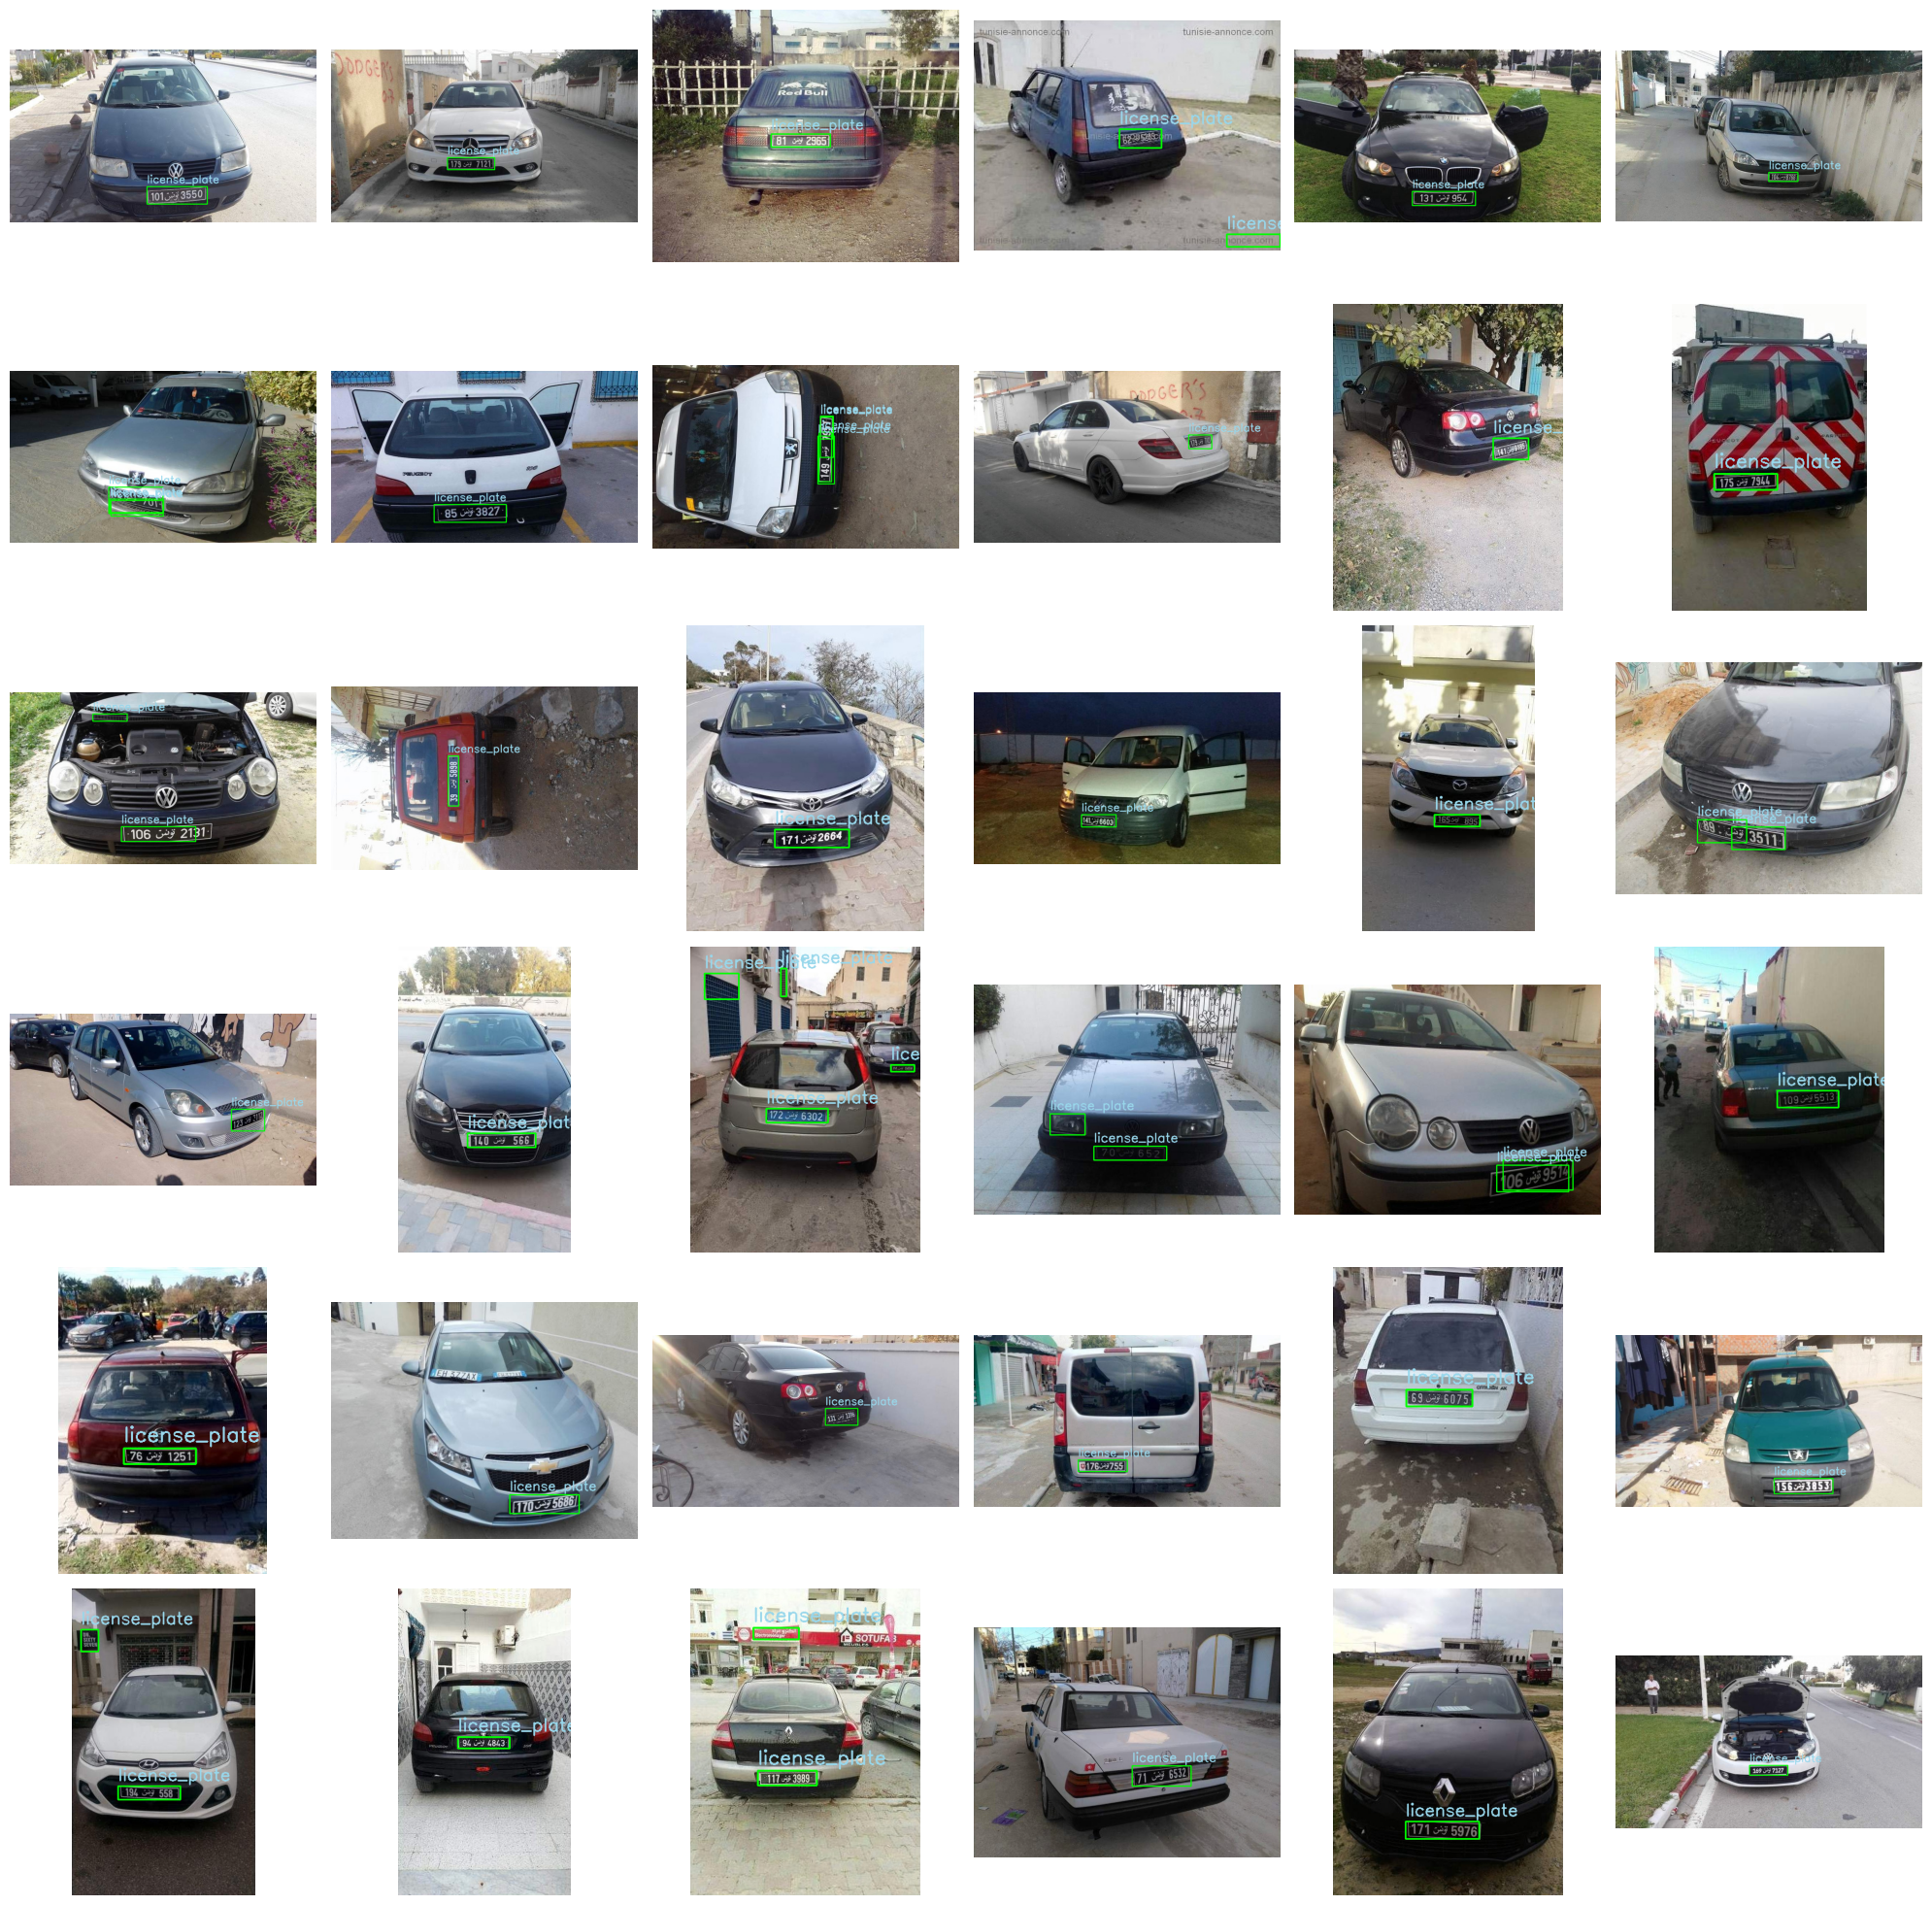

In [46]:
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import os

classes = ["license_plate"]

test_images_dir = 'datasets/car_plate/test/images'

test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.png') or f.endswith('.jpg')]

num_images = min(len(test_images), 36)

sample_images = random.sample(test_images, num_images)


fig, axs = plt.subplots(6, 6, figsize=(20, 20))


for i, image_path in enumerate(sample_images):
    row = i // 6
    col = i % 6

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = model.predict(image, imgsz=640)  

    for result in results[0].boxes:
        x1, y1, x2, y2 = map(int, result.xyxy[0])
        class_id = int(result.cls[0])
        label = classes[class_id]

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (152, 215, 235), 2)

    axs[row, col].imshow(image)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [47]:
import random
import os
import cv2
from ultralytics import YOLO

# Initialize your model
model = YOLO("runs/detect/train2/weights/best.pt")  

classes = ["license_plate"]

# Directories
test_images_dir = 'datasets/car_plate/test/images'
output_dir = 'output/images'
os.makedirs(output_dir, exist_ok=True)  
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.png') or f.endswith('.jpg')]

for image_path in test_images:
    image = cv2.imread(image_path)
    original_image = image.copy()
    results = model.predict(image, imgsz=640)

    for idx, result in enumerate(results[0].boxes):
        x1, y1, x2, y2 = map(int, result.xyxy[0])
        cropped_plate = original_image[y1:y2, x1:x2]
        output_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}_plate_{idx}.jpg")
        cv2.imwrite(output_path, cropped_plate)

print(f"Cropped license plates have been saved to {output_dir}.")



0: 384x640 1 licence_plate, 53.4ms
Speed: 1.7ms preprocess, 53.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 licence_plates, 57.9ms
Speed: 1.8ms preprocess, 57.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 licence_plate, 44.3ms
Speed: 2.0ms preprocess, 44.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 licence_plate, 61.2ms
Speed: 2.1ms preprocess, 61.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 licence_plate, 121.4ms
Speed: 3.0ms preprocess, 121.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 licence_plate, 77.6ms
Speed: 3.0ms preprocess, 77.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 licence_plate, 94.0ms
Speed: 3.0ms preprocess, 94.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 licence_plate, 76.0ms
Speed: 3.2ms preprocess, 76.0m

In [48]:
# okay, let's get done with ocr now


In [50]:
import os
import pytesseract
import cv2
import pandas as pd

output_dir = 'output/images'
csv_path = 'output/tesseract_results.csv' 

ocr_results = []

for image_file in os.listdir(output_dir):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        # Read the image
        image_path = os.path.join(output_dir, image_file)
        image = cv2.imread(image_path)

        text = pytesseract.image_to_string(image, config='--psm 7')  
        text = text.strip()
        ocr_results.append({'Image': image_file, 'Text': text})

df = pd.DataFrame(ocr_results)
df.to_csv(csv_path, index=False)

print(f"OCR results saved to {csv_path}.")


OCR results saved to output/tesseract_results.csv.
